Images inferred are stored on drive at MyDrive/Final_project/visualCheckForInferredImages.zip
<br><br>visualCheckForInferredImages is organised as follow:
<pre>
visualCheckForInferredImages/
│
└── HRInferenceImages
│
└──models_inference_results
              └──BSRGAN5000E
              └──HATT2000G
              └──REALESRGAN2500G
              └──SWINIR5000G
</pre>

#1 Install dependencies and import libraries

In [ ]:
!pip install basicsr -qqq
!pip install lpips -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
#Corrects import line from degradations.py as this version is obsolete
#https://github.com/xinntao/Real-ESRGAN/issues/801
#Note: if python version was updated on colab, change the file_path to correct one.
file_path = "/usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py"
line_to_replace = "from torchvision.transforms.functional_tensor import rgb_to_grayscale"
new_line = "from torchvision.transforms.functional import rgb_to_grayscale"

with open(file_path, 'r') as file:
    lines = file.readlines()

lines = [new_line if line.strip() == line_to_replace else line for line in lines]

with open(file_path, 'w') as file:
    file.writelines(lines)

print(f"Replacing line '{line_to_replace}' with '{new_line}' in file {file_path}")

Replacing line 'from torchvision.transforms.functional_tensor import rgb_to_grayscale' with 'from torchvision.transforms.functional import rgb_to_grayscale' in file /usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py


In [ ]:
from google.colab import drive
import cv2
import numpy as np
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from basicsr.metrics.niqe import calculate_niqe as basicsr_niqe
import lpips
import torch
from torchvision import transforms

# 2 Get images from drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# unzip the file
zip_path = "/content/drive/MyDrive/Final_project/visualCheckForInferredImages.zip"
extract_path = "/content/visualCheckForInferredImages"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Mounted at /content/drive


# 3 Get PSNR, SSIM, NIQE and LPIPS.

In [ ]:
def normalize_images(img_gt, img_pred):
    """
    Normalize two images to have same dimensions and 3-channel BGR format
    Returns: normalized_gt, normalized_pred
    """
    img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGRA2BGR)
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGRA2BGR)

    # Find common size
    min_height = min(img_gt.shape[0], img_pred.shape[0])
    min_width = min(img_gt.shape[1], img_pred.shape[1])

    # Trim both images to common size
    img_gt = img_gt[:min_height, :min_width]
    img_pred = img_pred[:min_height, :min_width]

    return img_gt, img_pred

In [ ]:
# Define PSNR on Y channel
def psnr_y(img_gt, img_pred):

    # Normalise images first
    img_gt, img_pred = normalize_images(img_gt, img_pred)

    # Convert to Y channel
    y_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    y_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2YCrCb)[:, :, 0]

    # Compute PSNR on Y channel
    mse = np.mean((y_gt.astype(np.float32) - y_pred.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

In [ ]:
# Define SSIM on Y channel
def ssim_y(img_gt, img_pred):

    # Normalize images first
    img_gt, img_pred = normalize_images(img_gt, img_pred)

    # Convert to Y channel
    y_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    y_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2YCrCb)[:, :, 0]

    # Compute SSIM on Y channel
    return ssim(y_gt, y_pred, data_range=255)

In [ ]:
# Define niqe on Y channel
def calculate_niqe(img):
    """
    Calculate NIQE score using BasicSR's implementation
    Uses Y channel (YCbCr) for calculation
    """
    # Convert to Y channel if the image is colour
    img_y = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    niqe_score = basicsr_niqe(img_y, crop_border=0)
    return niqe_score


In [ ]:
def calculate_lpips(img_gt, img_pred):
    """
    Calculate LPIPS score (lower is better)
    Uses RGB images as input and pre-initialized model
    """
    #lpips_available = True after being initialised
    if not lpips_available:
        return None

    # Normalize images first (both will be 3-channel BGR)
    img_gt, img_pred = normalize_images(img_gt, img_pred)

    # Convert from BGR to RGB (LPIPS expects RGB)
    img_gt_rgb = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
    img_pred_rgb = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)

    try:
        # Convert to tensors using pre-initialised transform
        gt_tensor = lpips_transform(img_gt_rgb).unsqueeze(0)
        pred_tensor = lpips_transform(img_pred_rgb).unsqueeze(0)

        # Calculate LPIPS using pre-initialised model
        with torch.no_grad():
            lpips_score = lpips_loss_fn(gt_tensor, pred_tensor)

        return lpips_score.item()

    except Exception as e:
        print(f"LPIPS calculation error: {e}")
        return None

In [ ]:
#Initialise LPIPS model. Vgg19 leades to RAM crashed error on T4 GPU
print("Initialising LPIPS model")
lpips_loss_fn = lpips.LPIPS(net='alex')
lpips_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
lpips_available = True
print("LPIPS model initialised successfully!")

Initialising LPIPS model
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 191MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS model initialised successfully!


In [ ]:
# Setup folders
gt_folder = os.path.join(extract_path, "HRInferenceImages")
models_folder = os.path.join(extract_path, "models_inference_results")

model_folders = ["BSRGAN5000E", "HAT2000G", "REALESRGAN2500G", "SWINIR5000G"]

results = []

In [ ]:
# Loop through models and compute all metrics
for model in model_folders:
    model_path = os.path.join(models_folder, model)
    for img_name in os.listdir(model_path):
        gt_path = os.path.join(gt_folder, img_name)
        pred_path = os.path.join(model_path, img_name)

        if os.path.exists(gt_path):
            gt_img = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
            pred_img = cv2.imread(pred_path, cv2.IMREAD_UNCHANGED)

            if gt_img is not None and pred_img is not None:
                try:
                    # Compute metrics on Y channel
                    psnr_value = psnr_y(gt_img, pred_img)
                    ssim_value = ssim_y(gt_img, pred_img)
                    niqe_value = calculate_niqe(pred_img)
                    lpips_value = calculate_lpips(gt_img, pred_img)

                    results.append([model, img_name, psnr_value, ssim_value, niqe_value, lpips_value])
                except Exception as e:
                    print(f"Error processing {img_name} in {model}: {str(e)}")
                    results.append([model, img_name, None, None, None, None])
            else:
                print(f"Could not read images: {img_name}")

In [ ]:
# Save all results to a csv
df_results = pd.DataFrame(results, columns=["folder_name", "image_name", "psnr_y", "ssim_y", "niqe", "lpips"])
csv_path = "/content/metrics_results_y.csv"
df_results.to_csv(csv_path, index=False)

print("metrics results saved to:", csv_path)
print(f"Processed {len(results)} images")

metrics results saved to: /content/metrics_results_y.csv
Processed 32 images


## 3.1 Create a score from NIQE and LPIPS to sort results

In [ ]:
# Read CSV
df = pd.read_csv("/content/metrics_results_y.csv")

# Compute score (lower niqe and lpips = better)
df["score"] = (1 - df["niqe"] / df["niqe"].max() + 1 - df["lpips"] / df["lpips"].max()) / 2

# Aggregate per image
df_img = df.groupby("image_name", as_index=False).agg({
    "niqe": "mean",
    "lpips": "mean",
    "score": "mean"
})

# Sort by score (higher = better)
df_sorted = df_img.sort_values("score", ascending=False)

print(df_sorted)

                             image_name      niqe     lpips     score
5                italystadiumAirbus.png  4.038242  0.309295  0.292766
4                  MaxarYellowStone.png  3.955832  0.331578  0.279541
0  AirbusDhirubhai_AmbaniSolarPlant.png  3.809389  0.348306  0.278160
1               AirbusRotterdamPort.png  4.260491  0.325343  0.254785
6                         pittsburg.png  4.190899  0.352691  0.235367
3                    MaxarIndonesia.png  4.260744  0.371449  0.210166
2             AirbusSantiagoAirport.png  3.673141  0.439674  0.203557
7                        plantation.png  3.528326  0.462049  0.196550


In [ ]:
# Best 2 images - to be used by error map
best_3 = df_sorted.head(3)

# Worst 2 images - to be used by reconstruction map
worst_3 = df_sorted.tail(3)

# Combine into one variable for display
top_bottom_3 = pd.concat([best_3, worst_3]).reset_index(drop=True)

print(top_bottom_3)


                             image_name      niqe     lpips     score
0                italystadiumAirbus.png  4.038242  0.309295  0.292766
1                  MaxarYellowStone.png  3.955832  0.331578  0.279541
2  AirbusDhirubhai_AmbaniSolarPlant.png  3.809389  0.348306  0.278160
3                    MaxarIndonesia.png  4.260744  0.371449  0.210166
4             AirbusSantiagoAirport.png  3.673141  0.439674  0.203557
5                        plantation.png  3.528326  0.462049  0.196550


# 4 kernel for edge detection

## 4.1 select a kernel from list

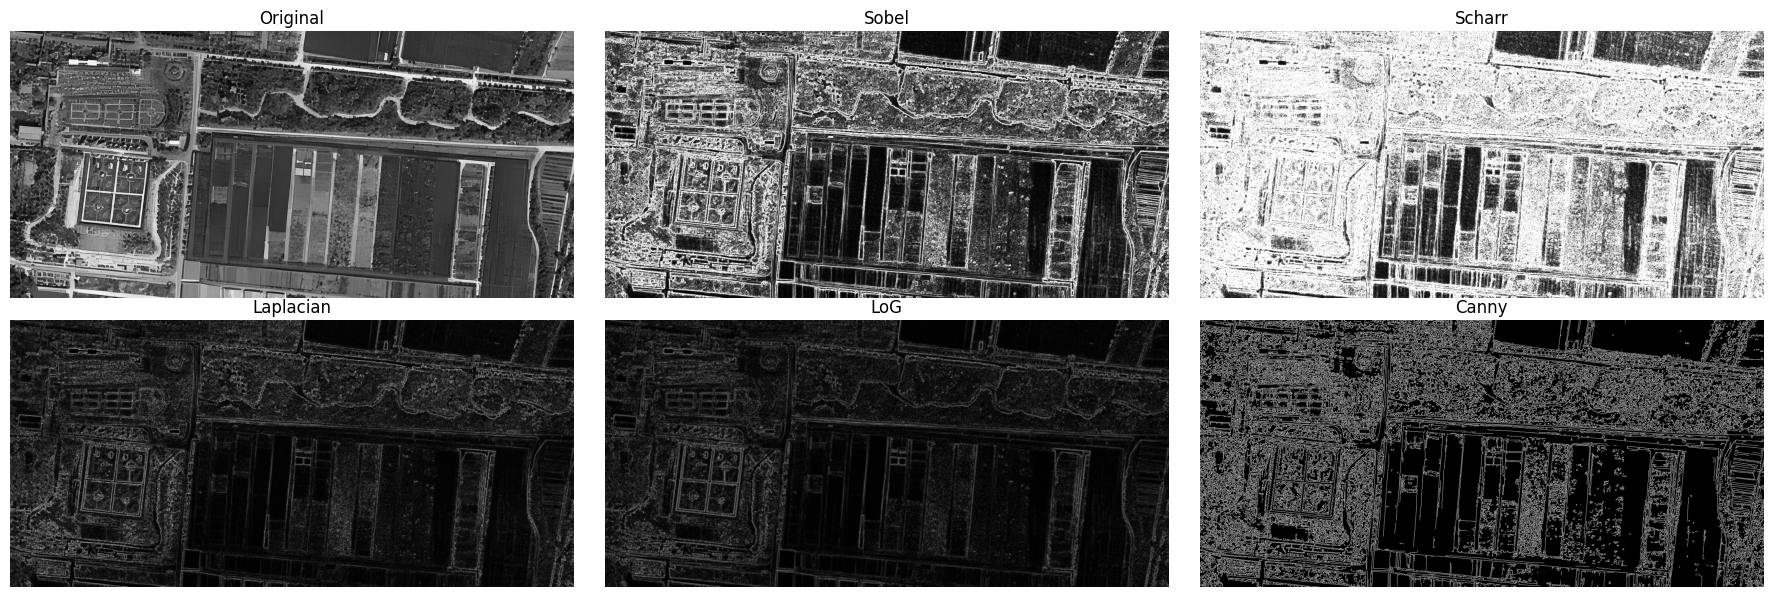

In [ ]:
# Path to worst image
img_path = "/content/visualCheckForInferredImages/models_inference_results/REALESRGAN2500G/plantation.png"

# Load image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 1 Sobel
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)
sobel = cv2.convertScaleAbs(sobel)

# 2 Scharr
scharrx = cv2.Scharr(img, cv2.CV_64F, 1, 0)
scharry = cv2.Scharr(img, cv2.CV_64F, 0, 1)
scharr = cv2.magnitude(scharrx, scharry)
scharr = cv2.convertScaleAbs(scharr)

# 3 Laplacian
laplacian = cv2.Laplacian(img, cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)

# 4 Laplacian of Gaussian
blur = cv2.GaussianBlur(img, (3,3), 0)
log = cv2.Laplacian(blur, cv2.CV_64F)
log = cv2.convertScaleAbs(log)

# 5 Canny
canny = cv2.Canny(img, 100, 180)

# Plot results
titles = ["Original", "Sobel", "Scharr", "Laplacian", "LoG", "Canny"]
images = [img, sobel, scharr, laplacian, log, canny]

plt.figure(figsize=(18,6))
for i, (title, image) in enumerate(zip(titles, images)):
    plt.subplot(2,3,i+1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 4.2 Apply Sobel to all images

In [ ]:
# Paths
gt_path = "/content/visualCheckForInferredImages/HRInferenceImages"
results_path = "/content/visualCheckForInferredImages/models_inference_results"
model_folders = ["BSRGAN5000E", "HAT2000G", "REALESRGAN2500G", "SWINIR5000G"]

# Output folder
output_folder = "/content/sobel_analysis"
os.makedirs(output_folder, exist_ok=True)

# Select top 3 and worst 3 images from df_sorted
top_images = df_sorted['image_name'].iloc[0:3].tolist()
worst_images = df_sorted['image_name'].iloc[-3:].tolist()
selected_images = top_images + worst_images

# Function to compute Sobel
def compute_sobel(img_gray):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)
    sobel = cv2.convertScaleAbs(sobel)
    return sobel

# Process Ground Truth images first
for img_name in selected_images:
    gt_img_path = os.path.join(gt_path, img_name)
    if os.path.exists(gt_img_path):
        gt_img = cv2.imread(gt_img_path, cv2.IMREAD_GRAYSCALE)
        gt_sobel = compute_sobel(gt_img)
        save_name = f"gt_{img_name.split('.')[0]}_sobel.png"
        cv2.imwrite(os.path.join(output_folder, save_name), gt_sobel)
    else:
        print(f"GT image not found: {gt_img_path}")

# Process images inferred by models
for img_name in selected_images:
    for model in model_folders:
        img_path = os.path.join(results_path, model, img_name)
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            sobel_img = compute_sobel(img)
            label = "top" if img_name in top_images else "worst"
            save_name = f"{label}_{img_name.split('.')[0]}_{model}_sobel.png"
            cv2.imwrite(os.path.join(output_folder, save_name), sobel_img)
        else:
            print(f"Model image not found: {img_path}")

print(f"All Sobel images saved in: {output_folder}")


All Sobel images saved in: /content/sobel_analysis


# 5 Error map analysis

In [ ]:
# Output folder for error maps
error_folder = "/content/sobel_analysis/errors"
os.makedirs(error_folder, exist_ok=True)

# Worst 3 images
worst_images = df_sorted['image_name'].iloc[-3:].tolist()

# Loop over worst images
for img_name in worst_images:
    # Load Ground Truth Sobel
    gt_sobel_path = os.path.join(output_folder, f"gt_{img_name.split('.')[0]}_sobel.png")
    gt_sobel = cv2.imread(gt_sobel_path, cv2.IMREAD_GRAYSCALE)
    gt_h, gt_w = gt_sobel.shape

    for model in model_folders:
        # Load model Sobel
        model_sobel_path = os.path.join(output_folder, f"worst_{img_name.split('.')[0]}_{model}_sobel.png")
        model_sobel = cv2.imread(model_sobel_path, cv2.IMREAD_GRAYSCALE)

        if model_sobel is not None:
            # Resize model Sobel to Ground Truth size
            model_sobel_resized = cv2.resize(model_sobel, (gt_w, gt_h), interpolation=cv2.INTER_LINEAR)

            # Compute absolute difference
            error = cv2.absdiff(gt_sobel, model_sobel_resized)

            # Create color overlay: green = errors
            color_gt = np.zeros((gt_h, gt_w, 3), dtype=np.uint8)
            color_gt[:,:,0] = 0
            color_gt[:,:,1] = error
            color_gt[:,:,2] = 0

            # Save error overlay
            save_name = f"error_{img_name.split('.')[0]}_{model}.png"
            cv2.imwrite(os.path.join(error_folder, save_name), color_gt)
        else:
            print(f"Model Sobel not found: {model_sobel_path}")

print(f"Error maps saved in: {error_folder}")


Error maps saved in: /content/sobel_analysis/errors


## 5.1 Get Mean Absolute Error and Edge Preservation Ratio

In [ ]:
# Paths
error_folder = "/content/sobel_analysis/errors"
gt_folder = "/content/sobel_analysis/"
model_folders = ["BSRGAN5000E", "HAT2000G", "REALESRGAN2500G", "SWINIR5000G"]

# Results table
results = []

# Loop over all error maps
for file in os.listdir(error_folder):
    if file.endswith(".png"):
        # Parse image name and model from file
        parts = file.replace(".png", "").split("_")
        img_name = parts[1]
        model = "_".join(parts[2:])

        # Load Ground truth Sobel
        gt_path = os.path.join(gt_folder, f"gt_{img_name}_sobel.png")
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if gt is None:
            print(f"GT not found: {gt_path}")
            continue

        # Load images inferred Sobel version
        model_path = os.path.join(error_folder, file)
        model_sobel = cv2.imread(model_path, cv2.IMREAD_GRAYSCALE)


        # MAE
        mae = np.mean(np.abs(gt.astype(np.float32) - model_sobel.astype(np.float32)))

        # Edge Preservation Ratio (EPR)
        # Threshold to binary edges: if above 50, then 1, else 0
        _, gt_bin = cv2.threshold(gt, 50, 1, cv2.THRESH_BINARY)
        _, model_bin = cv2.threshold(model_sobel, 50, 1, cv2.THRESH_BINARY)

        # Count overlapping edges
        # overlap = pixels where both GT and model have edges (1 & 1)
        # total = number of edge pixels in ground truth
        # epr = fraction of GT edges correctly preserved by model
        overlap = (gt_bin & model_bin).sum()
        total = gt_bin.sum()
        epr = overlap / total if total else 0

        # Save results
        results.append({
            "image_name": img_name,
            "model": model,
            "MAE": mae,
            "EPR": epr
        })

# Create DataFrame
df_error_metrics = pd.DataFrame(results)
df_error_metrics = df_error_metrics.sort_values(by="MAE")

df_error_metrics

,image_name,model,MAE,EPR
8,MaxarIndonesia,HAT2000G,41.913967,0.172825
4,MaxarIndonesia,SWINIR5000G,42.224850,0.166526
3,MaxarIndonesia,REALESRGAN2500G,42.552357,0.171529
7,MaxarIndonesia,BSRGAN5000E,42.930683,0.166045
5,plantation,HAT2000G,43.594711,0.260453
0,plantation,SWINIR5000G,43.909218,0.193175
9,plantation,REALESRGAN2500G,43.961586,0.263747
2,plantation,BSRGAN5000E,44.075428,0.264754
10,AirbusSantiagoAirport,SWINIR5000G,60.763031,0.314961
1,AirbusSantiagoAirport,HAT2000G,60.997509,0.307886


# 6 Reconstruction map analysis

In [ ]:
best_folder = "/content/sobel_analysis/best"
os.makedirs(best_folder, exist_ok=True)

#get 3 best images
top_images = df_sorted['image_name'].iloc[:3].tolist()

#Loop through the best images
for img_name in top_images:
  # Load ground truth sobel in grayscale
    gt_sobel_path = os.path.join(output_folder, f"gt_{img_name.split('.')[0]}_sobel.png")
    gt_sobel = cv2.imread(gt_sobel_path, cv2.IMREAD_GRAYSCALE)
    if gt_sobel is None:
        print(f"GT not found: {gt_sobel_path}")
        continue
    gt_h, gt_w = gt_sobel.shape

    for model in model_folders:
      #Load inferred images sobel version in grayscale
        model_sobel_path = os.path.join(output_folder, f"top_{img_name.split('.')[0]}_{model}_sobel.png")
        model_sobel = cv2.imread(model_sobel_path, cv2.IMREAD_GRAYSCALE)
        if model_sobel is None:
            print(f"Model Sobel not found: {model_sobel_path}")
            continue

        # Resize model Sobel to Ground Truth size
        model_sobel_resized = cv2.resize(model_sobel, (gt_w, gt_h), interpolation=cv2.INTER_LINEAR)

        # Compute pixel-wise overlap (normalised between 0–1)
        heat = (gt_sobel.astype(np.float32)/255.0) * (model_sobel_resized.astype(np.float32)/255.0)

        # Create empty RGB overlay
        overlay = np.zeros((gt_h, gt_w, 3), dtype=np.uint8)

        # Map heat to colors
        overlay[(heat >= 0.90)] = [0, 255, 0] #green for above 90
        overlay[(heat > 0.70) & (heat < 0.90)] = [255, 0, 0]  # blue channel high
        overlay[(heat >= 0.50) & (heat <= 0.70)] = [0, 0, 255]  # red low
        heat[heat < 0.5] = 0 #under 50 ignored

        # Convert original Sobel to 3-channel for background
        sobel_color = cv2.cvtColor(model_sobel_resized, cv2.COLOR_GRAY2BGR)

        # Blend Sobel background with coloured overlay
        final = cv2.addWeighted(sobel_color, 0.5, overlay, 0.8, 0)

        save_name = f"reconstructed_overlay_{img_name.split('.')[0]}_{model}.png"
        cv2.imwrite(os.path.join(best_folder, save_name), final)

print(f"Reconstructed overlay with threshold in: {best_folder}")


Reconstructed overlay with threshold in: /content/sobel_analysis/best


In [ ]:
# paths of top 3 images sobel version
gt_paths = [
    "/content/sobel_analysis/gt_AirbusDhirubhai_AmbaniSolarPlant_sobel.png",
    "/content/sobel_analysis/gt_italystadiumAirbus_sobel.png",
    "/content/sobel_analysis/gt_MaxarYellowStone_sobel.png"
]
pred_dir = "/content/sobel_analysis/"  # folder with top_<imagename>_<model>_sobel.png

# --- Helper functions ---
def load_binary(path):
    """Sobel images into clean 0/1 masks for computing true/false positive/negative.
       Pixels above 127 are considered edges else background.
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return (img > 127).astype(np.uint8)

def compute_f1_iou(gt_bin, pred_bin):
    """Compute F1 score and IoU"""
    TP = np.sum((pred_bin == 1) & (gt_bin == 1))
    FP = np.sum((pred_bin == 1) & (gt_bin == 0))
    FN = np.sum((pred_bin == 0) & (gt_bin == 1))

    f1 = 2 * TP / (2 * TP + FP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    return f1, iou

# Run evaluation
results = {}

for gt_path in gt_paths:
   # Extract base image name
    base_name = os.path.basename(gt_path).replace("gt_", "").replace("_sobel.png", "")
    results[base_name] = {}

    # Load ground truth as binary mask
    gt_bin = load_binary(gt_path)

    for pred_file in os.listdir(pred_dir):
        # Process only prediction Sobel images for this base image
        if pred_file.endswith("_sobel.png") and base_name in pred_file and "gt_" not in pred_file:
            model_name = pred_file.replace(f"top_{base_name}_", "").replace("_sobel.png", "")
            pred_path = os.path.join(pred_dir, pred_file)

            # Load inferred image and resize to match Ground Truth dimensions
            pred_bin = load_binary(pred_path)
            pred_bin = cv2.resize(pred_bin, (gt_bin.shape[1], gt_bin.shape[0]),
                                  interpolation=cv2.INTER_NEAREST)

            f1, iou = compute_f1_iou(gt_bin, pred_bin)
            results[base_name][model_name] = {"F1": f1, "IoU": iou}

# Print results
for img, model_metrics in results.items():
    print(f"\n{img}")
    for model, m in model_metrics.items():
        print(f"{model:15s} F1={m['F1']:.3f} IoU={m['IoU']:.3f}")



AirbusDhirubhai_AmbaniSolarPlant
SWINIR5000G     F1=0.503 IoU=0.336
REALESRGAN2500G F1=0.484 IoU=0.319
BSRGAN5000E     F1=0.474 IoU=0.310
HAT2000G        F1=0.519 IoU=0.350

italystadiumAirbus
HAT2000G        F1=0.626 IoU=0.456
SWINIR5000G     F1=0.622 IoU=0.452
REALESRGAN2500G F1=0.612 IoU=0.440
BSRGAN5000E     F1=0.622 IoU=0.452

MaxarYellowStone
SWINIR5000G     F1=0.493 IoU=0.327
HAT2000G        F1=0.509 IoU=0.341
BSRGAN5000E     F1=0.467 IoU=0.305
REALESRGAN2500G F1=0.478 IoU=0.314
